# Summary

This script is to processing the mass spectral embeddings into arrays and connect them to the class labels.



In [1]:
import os
import gensim
import pickle
import time
import sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from spec2vec.vector_operations import calc_vector
from collections import OrderedDict, Counter

## Import data from file

In [2]:
data_path = "/mnt/LTR_userdata/hooft001/mass_spectral_embeddings/datasets/ALL_GNPS_210409_positive/"
base = "ALL_GNPS_210409_positive_cleaned"
spectra_data = "_peaks_processed_s2v_only_annotated.pickle"

embedding_path = "/mnt/LTR_userdata/hooft001/mass_spectral_embeddings/embeddings/ALL_GNPS_210409_positive/ALL_GNPS_210409_positive_cleaned_spec2vec_embedding_iter_15.model"
save_path = "/mnt/scratch/ding013/MS2ChemClass/hooft_data/embedding_visualization_out/"

spectrum_file = os.path.join(data_path, base+".pickle")
os.path.exists(spectrum_file)

processed_spectrums_file = os.path.join(data_path, base+spectra_data)
with open(processed_spectrums_file, 'rb') as inf:
    spectrums_processed = pickle.load(inf)

len(spectrums_processed)

# TEST DATA
# spectrums_processed = spectrums_processed[1:100]
# len(spectrums_processed)


# ### Keep annotated spectra
# Annotated with inchikey

annot_spectrums_processed = []
for spec in spectrums_processed:
    inchikey = spec.metadata.get("inchikey")
    if inchikey:
        annot_spectrums_processed.append(spec)
len(annot_spectrums_processed)

spectrums_ids = [s.metadata.get("spectrum_id") for s in annot_spectrums_processed]


any([s==None for s in spectrums_ids])

False

## Create mass spectral embedding vectors

In [3]:
# ### Create spectral embedding vectors


# import model
model_file = os.path.join(embedding_path)
model = gensim.models.Word2Vec.load(model_file)


from spec2vec import SpectrumDocument

documents_spectrums_processed = [SpectrumDocument(s, n_decimals=2) for s in annot_spectrums_processed]
print(len(documents_spectrums_processed))


spectrum_vectors= [calc_vector(model, s, intensity_weighting_power=0.5) for s in documents_spectrums_processed]

spectrum_vectors = np.vstack(spectrum_vectors)
spectrum_vectors.shape

# and for UniqueInchikey
sys.path.insert(0, os.path.join(os.path.split(os.getcwd()[:-1])[0], "scripts"))

from mass_differences.processing import get_ids_for_unique_inchikeys ## This function is cited from Joris Louwen
uniq_ids = get_ids_for_unique_inchikeys(annot_spectrums_processed)


spectrum_vectors_unique = [spectrum_vectors[i] for i in uniq_ids]
spectrum_vectors_unique = np.vstack(spectrum_vectors_unique)
spectrum_vectors_unique.shape

187152


(16360, 300)

## Link classification labels to embeddings

In [4]:
# ### Link classification labels to selected spectra

classifications_path = "/mnt/LTR_userdata/hooft001/mass_spectral_embeddings/classifications/ALL_GNPS_210409_positive/"
classes_file = os.path.join(classifications_path, "ALL_GNPS_210409_positive_processed_annotated_CF_NPC_classes.txt")
classes = {}  # inchikey: [classes] in order of header
with open(classes_file) as inf:
    header = inf.readline().strip().split('\t')
    for line in inf:
        line = line.strip().split('\t')
        classes[line[0]] = line[2:]
print(f'read classes for {len(classes)} inchikeys')
print("\nclasses order:")
print(header)

spectra_classes = []
empty_class = ["" for _ in range(len(header)-2)]
assert len(empty_class) == len(header)-2
for s_id, spec in zip(spectrums_ids, annot_spectrums_processed):
    inchikey = spec.metadata.get("inchikey")
    s_classes = classes.get(inchikey, empty_class)
    assert len(s_classes) == len(header)-2
    res = [s_id] + s_classes
    spectra_classes.append(res)
print(len(spectra_classes))
print(spectra_classes[:2])

new_header = ['spectrum_id'] + header[2:]
assert len(new_header) == len(spectra_classes[0])
print(new_header)

read classes for 19824 inchikeys

classes order:
['inchi_key', 'smiles', 'cf_kingdom', 'cf_superclass', 'cf_class', 'cf_subclass', 'cf_direct_parent', 'npc_class_results', 'npc_superclass_results', 'npc_pathway_results', 'npc_isglycoside']
187152
[['CCMSLIB00000001547', 'Organic compounds', 'Organic acids and derivatives', 'Peptidomimetics', 'Hybrid peptides', 'Hybrid peptides', 'Cyclic peptides; Microcystins', 'Oligopeptides', 'Amino acids and Peptides', '0'], ['CCMSLIB00000001548', 'Organic compounds', 'Organic acids and derivatives', 'Peptidomimetics', 'Depsipeptides', 'Cyclic depsipeptides', 'Cyclic peptides', 'Oligopeptides', 'Amino acids and Peptides', '0']]
['spectrum_id', 'cf_kingdom', 'cf_superclass', 'cf_class', 'cf_subclass', 'cf_direct_parent', 'npc_class_results', 'npc_superclass_results', 'npc_pathway_results', 'npc_isglycoside']


In [5]:
spectra_classes[0]

['CCMSLIB00000001547',
 'Organic compounds',
 'Organic acids and derivatives',
 'Peptidomimetics',
 'Hybrid peptides',
 'Hybrid peptides',
 'Cyclic peptides; Microcystins',
 'Oligopeptides',
 'Amino acids and Peptides',
 '0']

### Get the ordered classification labels

In [6]:
# i_chosen = -4  # npc_class # choose which class (npc/cf) to plot (in new_header)
# i_chosen = 3 # cf_class

## Collect the ordered labels in all classes
all_classes_ori = []
for lbs in range(1,len(new_header)):
    print(new_header[lbs])
    chosen_classes_ori = []
    uncl = "Unclassified"
    uncl_other = "Other/Unclassified"
    add_uncl = False
    for s_cl in spectra_classes:
        chosen_class = s_cl[lbs]
        if not chosen_class:
            chosen_class = uncl
        else:  # separate in single classes - there are compounds with 3 superclasses for example
            chosen_class = chosen_class.split("; ")[0]
        chosen_classes_ori.append(chosen_class)
    len(chosen_classes_ori)
    all_classes_ori.append(chosen_classes_ori)
len(all_classes_ori)

cf_kingdom
cf_superclass
cf_class
cf_subclass
cf_direct_parent
npc_class_results
npc_superclass_results
npc_pathway_results
npc_isglycoside


9

In [7]:
## Collect the orderen labels with unique inchikey in all classes
all_classes_ori_ui = []
for k in all_classes_ori:
    chosen_classes_ori_ui = [k[i] for i in uniq_ids]
    len(chosen_classes_ori_ui)
    all_classes_ori_ui.append(chosen_classes_ori_ui)
len(all_classes_ori_ui)

9

## Save array as csv file

In [8]:
## Save the spectral embeddings array with unique inchikey

X_embedding = np.array(spectrum_vectors_unique)
np.savetxt('/mnt/scratch/ding013/MS2ChemClass/embedding_arrays_for_classification/X_spectral_embeddings.csv', X_embedding, delimiter=',')

In [9]:
## Save the ordered class labels array with unique inchikey
for i in range(len(all_classes_ori_ui)):
    y_label = np.array(all_classes_ori_ui[i])
    print(new_header[i+1])
    filepath_labels='/mnt/scratch/ding013/MS2ChemClass/embedding_arrays_for_classification/y_%s_labels.csv' % new_header[i+1]
    np.savetxt(filepath_labels, y_label, delimiter=',',fmt='%s')

cf_kingdom
cf_superclass
cf_class
cf_subclass
cf_direct_parent
npc_class_results
npc_superclass_results
npc_pathway_results
npc_isglycoside


## Inspect the distribution of classification labels

In [15]:
npc_class_ui = all_classes_ori_ui[5] # Choose the labels in Class level
len(npc_class_ui)

16360

In [16]:
label_distri = {i: npc_class_ui.count(i) for i in npc_class_ui}

In [18]:
len(label_distri)
label_distri

{'Cyclic peptides': 557,
 'Unclassified': 3309,
 'Lipopeptides': 11,
 'Linear peptides': 169,
 'Tripeptides': 109,
 'Open-chain polyketides': 74,
 'Ansa macrolides': 61,
 'Angucyclines': 32,
 'Polyene macrolides': 23,
 'Aminoacids': 221,
 'Scalarane sesterterpenoids': 4,
 'Cholestane steroids': 77,
 'Chromones': 88,
 'N-acyl amines': 108,
 'Lactones': 20,
 'Naphthoquinones': 51,
 'Depsipeptides': 17,
 'Spirotetronate macrolides': 10,
 'Actinomycins': 7,
 'Macrolide lactones': 16,
 'Dipeptides': 299,
 'Fatty aldehydes': 6,
 'Chamigrane sesquiterpenoids': 2,
 'Simple amide alkaloids': 3,
 'Farnesane sesquiterpenoids': 9,
 'Wax monoesters': 60,
 'Glycerophosphoethanolamines': 91,
 'Cyclamides': 4,
 'Cyanopeptolins': 12,
 'RiPPs': 19,
 'Anabaenopeptins': 12,
 'Bisnaphthalenes': 12,
 'Monosaccharides': 34,
 'Quinoline alkaloids': 88,
 'RiPPs-Thiopeptides': 4,
 '2-pyrone derivatives': 45,
 'Phenazine alkaloids': 44,
 'Unsaturated fatty acids': 46,
 'Carbocyclic fatty acids': 8,
 'Sphingoid b

In [ ]:
label_distri.items

In [22]:
uniq_label = [i for i, j in label_distri.items() if j==1]
print(len(uniq_label))
uniq_label = [i for i, j in label_distri.items() if j==2]
print(len(uniq_label))
uniq_label = [i for i, j in label_distri.items() if j==3]
print(len(uniq_label))
uniq_label = [i for i, j in label_distri.items() if j==4]
print(len(uniq_label))

72
41
27
16


In [26]:
#sorted_label_distri = sorted(label_distri, key=label_distri.get, reverse=True)
#print(len(sorted_label_distri))

sorted_label_distri = dict(sorted(label_distri.items(), key=lambda item: item[1], reverse=True))

In [32]:
list(sorted_label_distri.items())[:10]

[('Unclassified', 3309),
 ('Cyclic peptides', 557),
 ('Simple coumarins', 531),
 ('Pyridine alkaloids', 394),
 ('Dipeptides', 299),
 ('Flavones', 279),
 ('Flavonols', 271),
 ('Oleanane triterpenoids', 259),
 ('Carboline alkaloids', 252),
 ('Triacylglycerols', 247)]

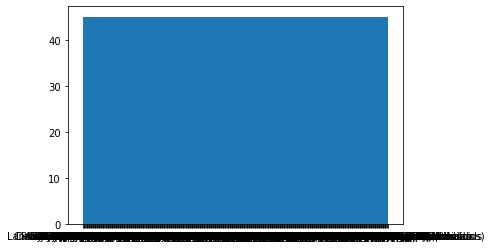

In [33]:
plt.hist(sorted_label_distri)
plt.show()